In [4]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import h5py
import keras
from keras.datasets import mnist
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras_tqdm import TQDMNotebookCallback
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint


# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [5]:
#load data
def load_dataset(file):
  h5f = h5py.File(file, 'r')
  dataset, labels = h5f["dataset"][:], h5f["labels"][:]
  h5f.close()
  return dataset, labels

def split_dataset(dataset, label_dataset, valid_size):
  size = len(dataset)
  return dataset[:size - valid_size, :, :], label_dataset[:size - valid_size], dataset[size - valid_size: size, :, :], label_dataset[size - valid_size:size]

x_test, y_test = load_dataset('not_mnist_dataset_full_test.h5')
print('Test set ', x_test.shape, y_test.shape)
x_train_val, y_train_val = load_dataset('not_mnist_dataset_full_train.h5')
x_train, y_train, x_valid, y_valid = split_dataset(x_train_val, y_train_val, 18000)
print('Train set ', x_train.shape, y_train.shape)
print('Valid set ', x_valid.shape, y_valid.shape)

Test set  (18726, 28, 28) (18726,)
Train set  (511119, 28, 28) (511119,)
Valid set  (18000, 28, 28) (18000,)


In [7]:
image_size = 28
num_channels = 1
pixel_depth = 255
num_classes = 10
epochs = 5
batch_size=32
model_dir='not_mnist_dir/'
model_arch_file = model_dir + 'model_arch.json'
model_checkPoint_file = model_dir + 'model_checkpoint.h5'
model_final_file = model_dir + 'model_final.h5'
keras.utils.to_categorical(y_test, num_classes).shape

(18726, 10)

In [8]:
#reformat
def reformat(dataset, labels):
    dataset = dataset.reshape(-1, image_size, image_size, num_channels).astype(np.float32)
    dataset /= pixel_depth
    labels = (np.arange(num_classes) == labels[:,None]).astype(np.float32)
    #keras.utils.to_categorical(y_test, num_classes).shape
    return dataset, labels

x_train_r, y_train_r = reformat(x_train, y_train)
x_valid_r, y_valid_r = reformat(x_valid, y_valid)
x_test_r, y_test_r = reformat(x_test, y_test)
print('Train set ', x_train_r.shape, x_train_r.shape)
print('Valid set ', x_valid_r.shape, x_valid_r.shape)
print('Test set ', x_test_r.shape, x_test_r.shape)

Train set  (511119, 28, 28, 1) (511119, 28, 28, 1)
Valid set  (18000, 28, 28, 1) (18000, 28, 28, 1)
Test set  (18726, 28, 28, 1) (18726, 28, 28, 1)


In [11]:
#model
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=x_train_r.shape[1:]))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
model.add(Conv2D(64, kernel_size=(5,5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model_json = model.to_json()
with open(model_arch_file, 'w') as f:
    f.write(model_json)

In [12]:
#Train
with open(model_arch_file, 'r') as f:
    model_json = f.read()
    model = model_from_json(model_json)
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
#grad = keras.optimizers.SGD(lr=0.01)
rLR = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
model.compile(optimizer = adam,
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
callbacks = [ModelCheckpoint(model_checkPoint_file, verbose=1), 
             TQDMNotebookCallback(leave_inner=True),
             rLR]
history_model = model.fit(x_train_r, y_train_r, batch_size, epochs=epochs, verbose=0, 
                        validation_data=(x_valid_r, y_valid_r), shuffle=True, callbacks=callbacks)
model.save(model_final_file)

A Jupyter Widget

A Jupyter Widget

Epoch 00000: saving model to not_mnist_dir/model_checkpoint.h5


A Jupyter Widget

Epoch 00001: saving model to not_mnist_dir/model_checkpoint.h5


A Jupyter Widget

Epoch 00002: saving model to not_mnist_dir/model_checkpoint.h5


A Jupyter Widget

Epoch 00003: saving model to not_mnist_dir/model_checkpoint.h5


A Jupyter Widget

Epoch 00004: saving model to not_mnist_dir/model_checkpoint.h5



18560/18726 [============================>.] - ETA: 0s
 Test Loss: 0.0954748119398
Test Accuracy 0.973192352878
dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


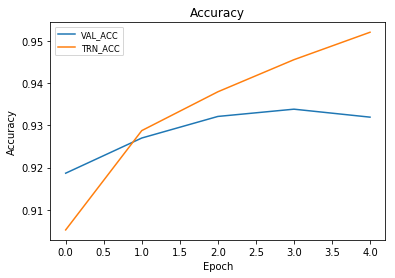

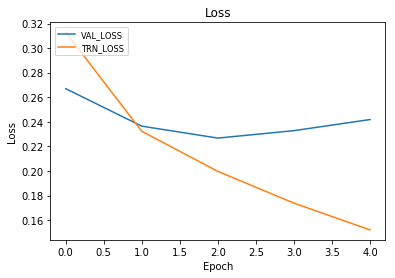

In [14]:
score = model.evaluate(x_test_r, y_test_r)
print('\n','Test Loss:', score[0])
print('Test Accuracy', score[1])
print(history_model.history.keys())
val = plt.plot(history_model.history['val_categorical_accuracy'], label='VAL_ACC')
trn = plt.plot(history_model.history['categorical_accuracy'], label='TRN_ACC')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc=2, fontsize="small")
plt.show()
plt.plot(history_model.history['val_loss'], label='VAL_LOSS')
plt.plot(history_model.history['loss'], label='TRN_LOSS')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc=2, fontsize="small")
plt.show()

In [15]:
history_model.history['val_categorical_accuracy']

[0.91866666666666663,
 0.92700000000000005,
 0.93211111111111111,
 0.93383333333333329,
 0.93194444444444446]

In [16]:
history_model.history['categorical_accuracy']

[0.90523146273188748,
 0.9287563170220634,
 0.93795182726539139,
 0.94555670988556484,
 0.95205813127690264]